# LIB

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error



# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/dataset/MSFT.csv'
df = pd.read_csv(data_dir, parse_dates= True , index_col= "Date")



# Data Exploration

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9083 entries, 1986-03-13 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9083 non-null   float64
 1   High       9083 non-null   float64
 2   Low        9083 non-null   float64
 3   Close      9083 non-null   float64
 4   Adj Close  9083 non-null   float64
 5   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 496.7 KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9083.000000,9083.000000,9083.000000,9083.000000,9083.000000,9.083000e+03
mean,41.324936,41.760887,40.878488,41.335628,36.256120,5.875055e+07
std,59.696905,60.272218,59.081728,59.714567,59.981436,3.845200e+07
min,0.088542,0.092014,0.088542,0.090278,0.057046,2.304000e+06
25%,4.050781,4.102051,4.027344,4.075195,2.575089,3.461230e+07
50%,26.820000,27.100000,26.520000,26.840000,18.948530,5.203200e+07
75%,40.034999,40.443751,39.500000,39.937500,29.244812,7.265400e+07
max,344.619995,349.670013,342.200012,343.109985,342.402008,1.031789e+09


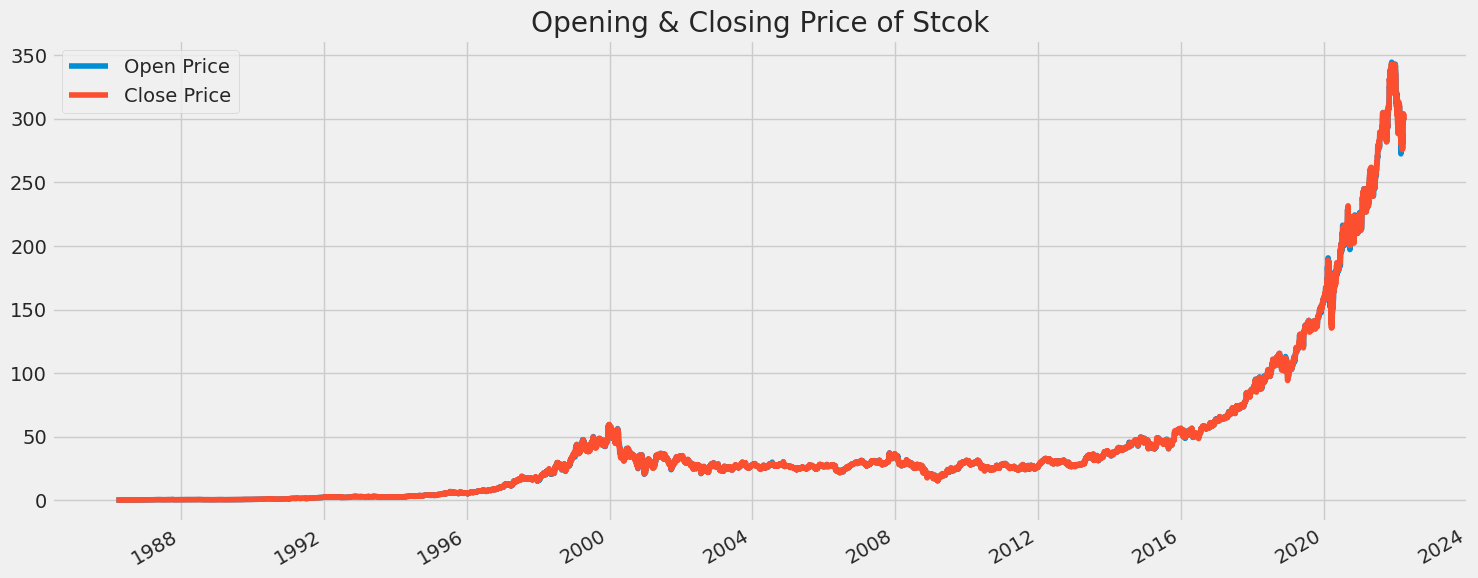

In [ ]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Stcok")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

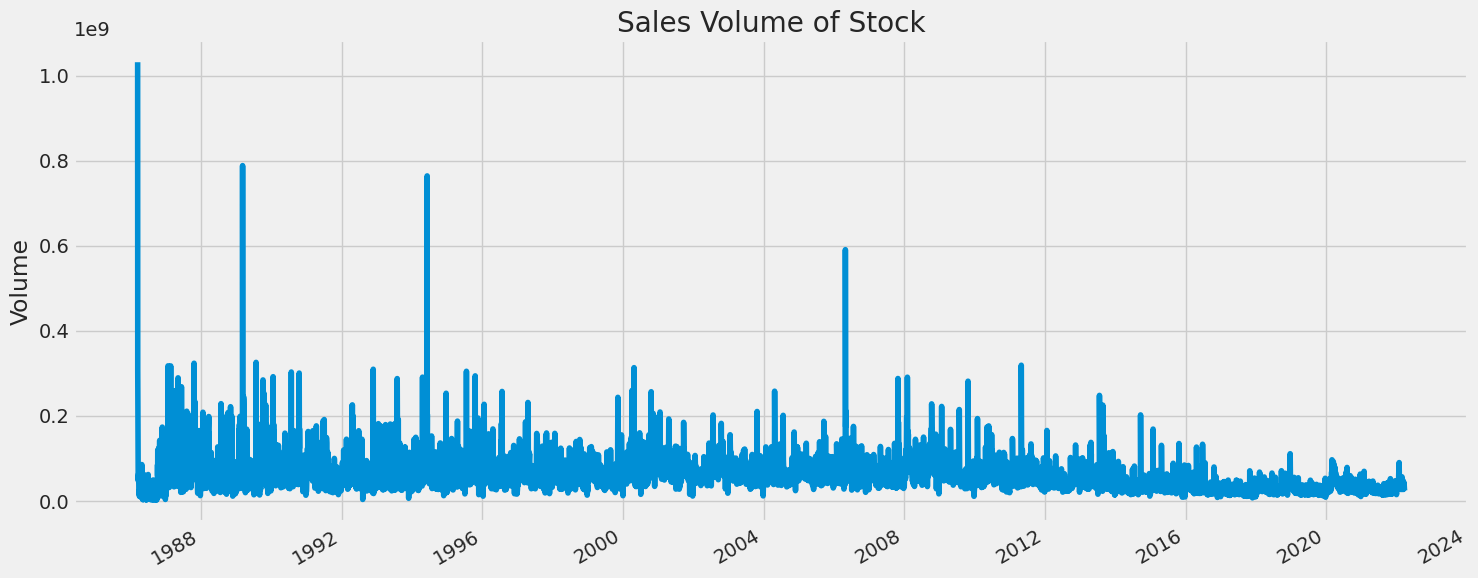

In [ ]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Stock")
plt.tight_layout()
plt.show()

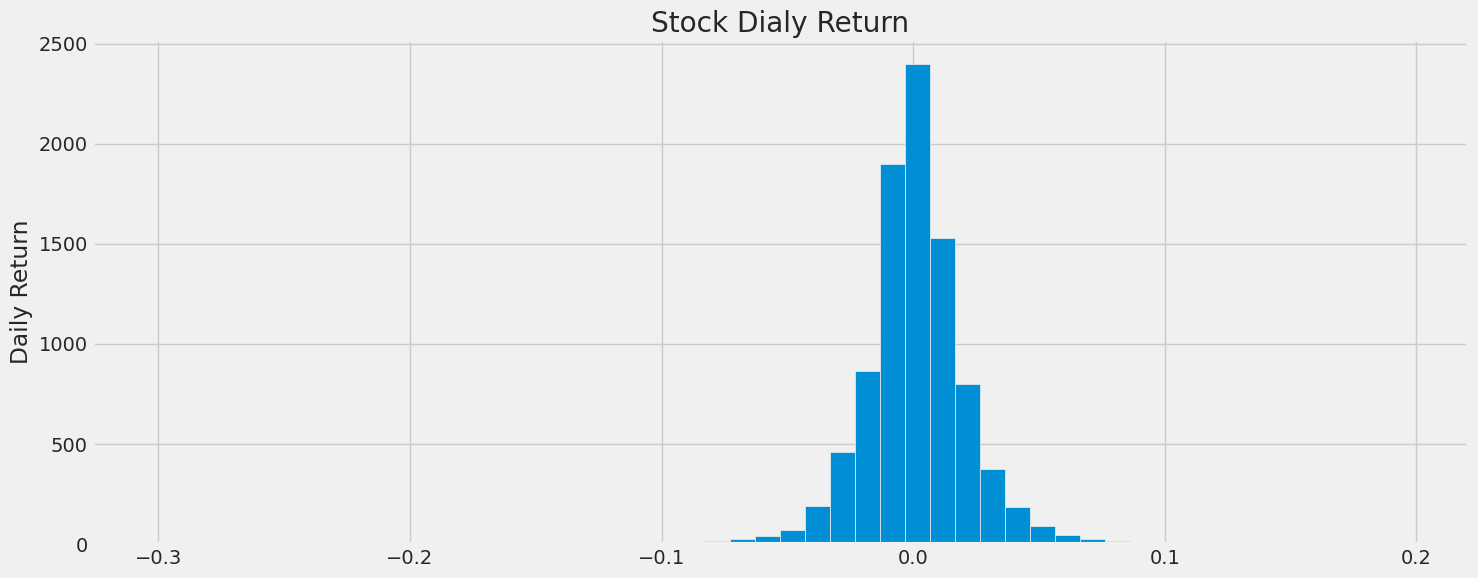

In [ ]:
# We'll use pct_change to find the percent change for each day
plt.figure(figsize=(15, 6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Stock Dialy Return')
plt.tight_layout()
plt.show()

# Data Preprocessing

Choosing Prediction Column

In [ ]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(9083, 1)

Normalizing Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

Splitting the Data

In [ ]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 6812 Test Size : 2271


In [ ]:
train_data.shape, test_data.shape

((6812, 1), (2331, 1))

Creating training set

In [ ]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train.shape , y_train.shape

((6752, 60, 1), (6752,))

# Model

Model Dtructure

In [ ]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

Model Training

In [ ]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - loss: 2.7730e-04 - mean_absolute_error: 0.0089
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 1.4422e-05 - mean_absolute_error: 0.0025
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 1.0726e-05 - mean_absolute_error: 0.0023
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 1.0811e-05 - mean_absolute_error: 0.0023
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 9.8302e-06 - mean_absolute_error: 0.0022
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 9.3510e-06 - mean_absolute_error: 0.0021
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 8.5132e-06 - mean_absolute_error: 0.0021
Epoch 8/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 6.2499e-06 - mean_absolute_error: 0.0017
Epoch 9/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 7.2646e-06 - mean_absolute_error: 0.0019
Epoch 10/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 5

Model Evaluation

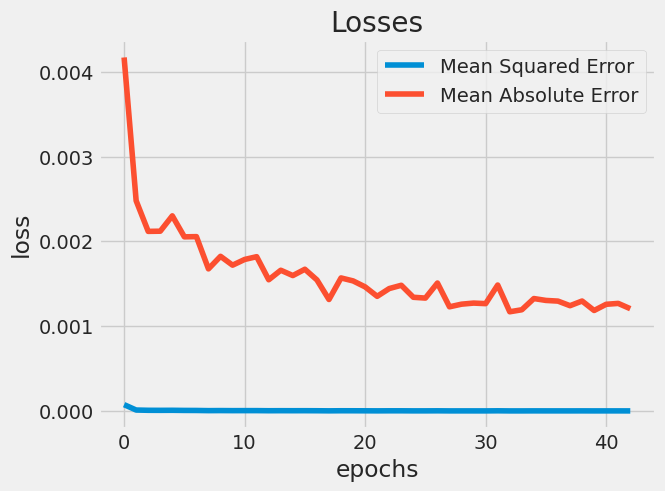

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Predection

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape , y_test.shape

((2271, 60, 1), (2271,))

In [ ]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


(2271, 1)

Root mean square error

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.39

Visualize Predictions with The Data

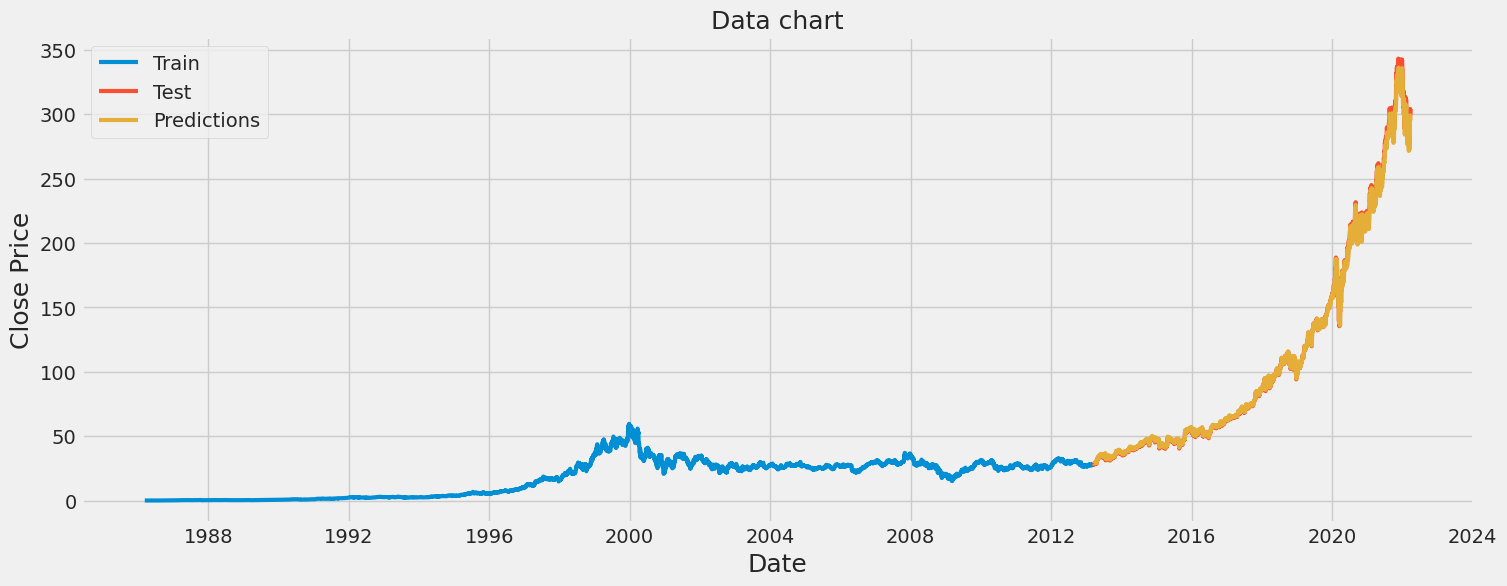

In [ ]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Data chart', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Result

In [ ]:
from datetime import timedelta

In [ ]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [ ]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.8607628]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.8607628, 0.84799093]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.8607628, 0.84799093, 0.8354571]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503, 0.81212866]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503, 0.81212866, 0.801185]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503, 0.81212866, 0.801185, 0.79049826]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503, 0.81212866, 0.801185, 0.79049826, 0.7799371]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503, 0.81212866, 0.801185, 0.79049826, 0.7799371, 0.7694373]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.8607628, 0.84799093, 0.8354571, 0.823503, 0.81212866, 0.801185, 0.79049826, 0.7799371, 0.7694373, 0.7589975

In [ ]:
time

[Timestamp('2022-03-24 00:00:00'),
 Timestamp('2022-03-25 00:00:00'),
 Timestamp('2022-03-26 00:00:00'),
 Timestamp('2022-03-27 00:00:00'),
 Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-03-29 00:00:00'),
 Timestamp('2022-03-30 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-04 00:00:00'),
 Timestamp('2022-04-05 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-07 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-10 00:00:00'),
 Timestamp('2022-04-11 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-13 00:00:00'),
 Timestamp('2022-04-14 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-16 00:00:00'),
 Timestamp('2022-04-17 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-19 00:00:00'),
 Timestamp('2022-04-20 00:00:00'),
 Timestamp('2022-04-

In [ ]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [ ]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

Forecasted tesla close price

In [ ]:
df_result

,Date,Forecasted
0,2022-03-24,295.348877
1,2022-03-25,290.967896
2,2022-03-26,286.668518
3,2022-03-27,282.568054
4,2022-03-28,278.666412
5,2022-03-29,274.912537
6,2022-03-30,271.246765
7,2022-03-31,267.624084
8,2022-04-01,264.022461
9,2022-04-02,260.441376


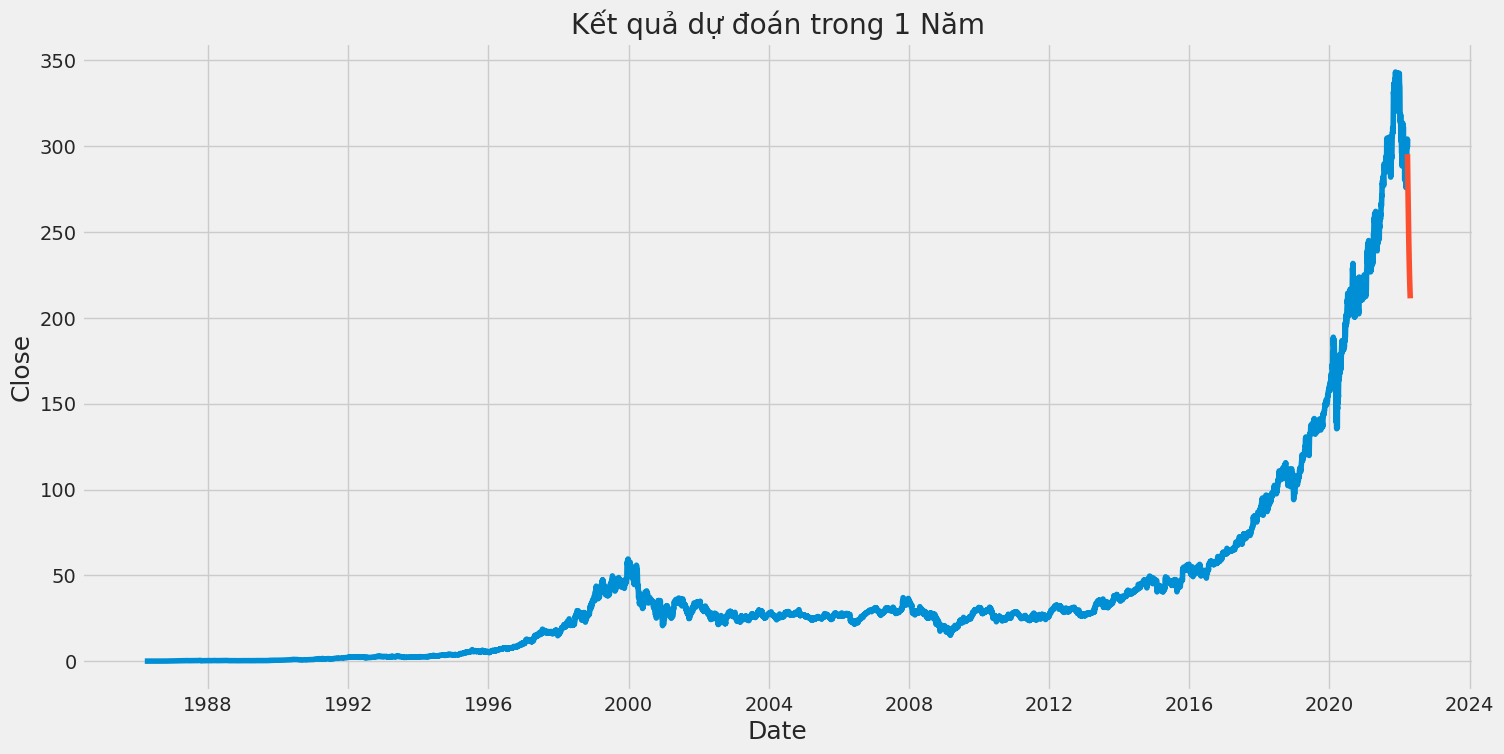

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Kết quả dự đoán trong 1 Năm')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])